## Abstract

Despite the header being `## Abstract`, this section will render as a highlighted section titled *Summary*. Ensure this section is a **maximum** of 280 characters.

----

:::{.callout-note title="AI usage disclosure" collapse="true"}
This is a placeholder for the AI usage disclosure. Once all authors sign the AI code form on Airtable, SlackBot will message you an AI disclosure that you should place here.
:::

## Purpose

Once edited by you, this file will become your publication. Alternatively, if you already have a notebook written that you're trying to transform into a pub, replace this file with your own, but be sure to add the YAML front matter (the first cell) to your notebook.

Your pub should begin with a section titled **Purpose** where you, as briefly as possible, explain why you did the work described in the pub, the key takeaway, your primary audience, and how you think it could be useful to them/why you're sharing it.

## Introduction

The MSA Pairformer (2025.08.02.668173v1) introduces a 111M-parameter architecture that leverages multiple sequence alignments and a query-biased pair representation to achieve state-of-the-art performance in contact prediction, protein–protein interface identification, and variant effect prediction. Beyond benchmarks, the paper advances a mechanistic claim: that the model mitigates phylogenetic averaging by weighting sequences according to their evolutionary relevance to the query, thereby recovering subfamily-specific signals.

This interpretation hinges on an assumption that has not been directly tested: that learned sequence weights align with phylogenetic similarity, not merely raw sequence identity. The authors provide indirect evidence—bimodal weight distributions within the response regulator family, improved recovery of subfamily-specific contacts, and weight–identity correlations—but these do not establish whether the model is actually sensitive to tree-based lineage structure.

In this notebook, we examine the relationship between learned sequence weights and phylogenetic distance. Our goal is not to challenge the reported performance, but to evaluate the evolutionary interpretation. By linking weights to tree-based measures of relatedness, we can clarify whether the Pairformer is genuinely capturing subfamily-specific phylogenetic signal, or whether its behavior is better explained by local sequence identity and compositional effects.

## Re-examining the Response Regulator Case Study

The original paper highlights the response regulator (RR) family as a case study for subfamily-specific signal. There, query-biased weights displayed a bimodal distribution: sequences belonging to the same subfamily as the query were consistently upweighted, while sequences from other subfamilies were downweighted. This was presented as evidence that the model captures lineage structure, rather than relying solely on raw sequence identity.

To evaluate this claim more directly, we begin by reproducing the RR multiple sequence alignment (MSA) used in the paper. This alignment serves as the foundation for both the subfamily analysis and our subsequent phylogenetic analysis. By rebuilding the MSA in a transparent, reproducible way, we can:

Confirm that the alignment and sequence set are comparable to those used in the published case study.

Provide input to the MSA Pairformer, enabling us to extract query-biased weights via a forward pass.

Establish a consistent dataset on which to perform downstream analyses, including the correlation of weights with tree-based phylogenetic distances.

In the next cell, we will generate the RR MSA. This involves identifying the same protein family and constructing the alignment under similar constraints (e.g., filtering thresholds, depth caps). The resulting MSA will then be used as input to the model, forming the basis of our re-analysis.

In [7]:
from pathlib import Path

from analysis.pfam import download_and_process_response_regulator_msa
from analysis.tree import read_newick, run_fasttree

from MSA_Pairformer.dataset import MSA

response_regulator_dir = Path("./data/response_regulators")
response_regulator_dir.mkdir(parents=True, exist_ok=True)

msas: dict[str, MSA] = {}
trees: dict[str, MSA] = {}

queries = ["1NXS", "4CBV", "4E7P"]
for query in queries:
    msa_path = response_regulator_dir / f"PF00072.final_{query}.a3m"
    fasttree_path = response_regulator_dir / f"PF00072.final_{query}.fasttree.newick"

    if not msa_path.exists():
        download_and_process_response_regulator_msa(
            output_dir=response_regulator_dir,
            query=query,
            subset_size=4096,
            keep_intermediate=True,
        )

    msas[query] = MSA(msa_file_path=msa_path, diverse_select_method="none")

    if not fasttree_path.exists():
        run_fasttree(msa_path, fasttree_path)

    trees[query] = read_newick(fasttree_path)

In [10]:
from typing import Any

import torch
from analysis.data import get_model_input_data

from MSA_Pairformer.model import MSAPairformer

device = "cpu"
model = MSAPairformer.from_pretrained(device=device)

# FIXME
for query in queries:
    msas[query] = MSA(
        response_regulator_dir / f"PF00072.small_{query}.a3m", diverse_select_method="none"
    )
    trees[query] = read_newick(response_regulator_dir / f"PF00072.small_{query}.fasttree.newick")

inference_results_path = response_regulator_dir / "inference_results.pt"
if inference_results_path.exists():
    inference_results = torch.load(inference_results_path)
else:
    inference_results: dict[str, dict[str, Any]] = {}

    for query in queries:
        with torch.no_grad(), torch.amp.autocast(dtype=torch.bfloat16, device_type=device):
            inference_results[query] = model(
                return_seq_weights=True,
                query_only=True,
                **get_model_input_data(msas[query], device),
            )

    torch.save(inference_results, inference_results_path)

Fetching 6 files: 100%|██████████| 6/6 [00:00<00:00, 46863.73it/s]
/var/folders/v4/q0wyvpsj4h901lfkjcln68nw0000gn/T/ipykernel_94444/2055373389.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this e

If you were interested in taking this analysis a different direction, this would be a great branching point. Though in this pub we're going to focus exclusively on the sequence weights produced by the query biased outer product operation. To do that, we'll store the sequence weights relative to the query sequence for each layer, as well as the median sequence bias across layers, which was used in Figure FIXME. 

In [23]:
import pandas as pd
from analysis.data import get_sequence_weight_data
from analysis.tree import get_patristic_distance

data_dict = dict(
    query=[],
    target=[],
    median_weight=[],
    patristic_distance=[],
)

for query in queries:
    msa = msas[query]
    tree = trees[query]
    targets = msa.ids_l

    patristic_distances = get_patristic_distance(tree, query)[targets]
    weights = get_sequence_weight_data(inference_results[query])
    median_weights = torch.median(weights, dim=0).values

    data_dict["query"].extend([query] * len(targets))
    data_dict["target"].extend(targets)
    data_dict["median_weight"].extend(median_weights.tolist())
    data_dict["patristic_distance"].extend(patristic_distances.tolist())

response_regulator_df = pd.DataFrame(data_dict).query("query != target").reset_index(drop=True)
response_regulator_df

,query,target,median_weight,patristic_distance
0,1NXS,A0A7H5F465_9BACT/11-124,0.083631,2.677642
1,1NXS,S0JI73_9FIRM/4-121,0.088835,2.391105
2,1NXS,A0A4P8XPW8_9BACL/7-119,0.071960,3.245795
3,1NXS,A0A1U9NKQ4_9BACT/11-121,0.081426,2.859413
4,1NXS,A0A133YF07_9FIRM/5-118,0.085592,2.571722
5,1NXS,K9HX42_9PROT/8-119,0.074406,3.120490
6,1NXS,R5U4R4_9BACE/8-123,0.073449,2.864130
7,1NXS,A0A0C1KZ80_9BACT/5-117,0.078618,3.017138
8,1NXS,A0A1B7K1R1_9GAMM/5-117,0.082850,2.691065
9,4CBV,A0A127FE09_STEDE/7-119,0.075682,3.250627


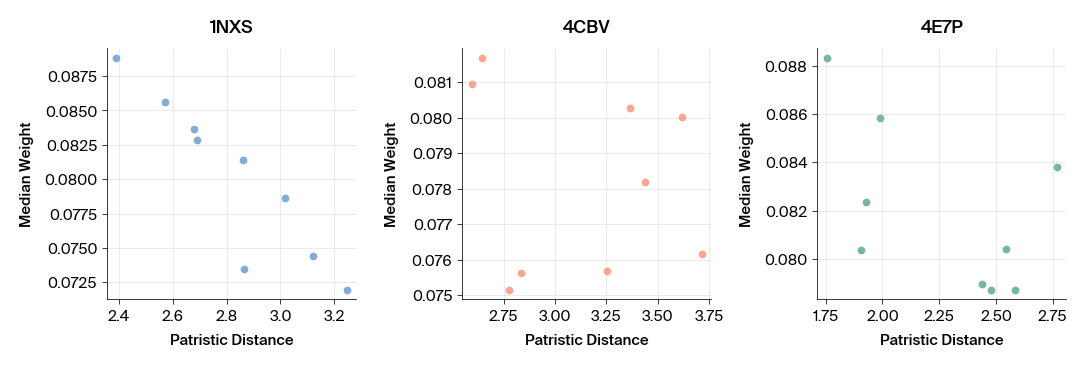

In [29]:
import arcadia_pycolor as apc
import matplotlib.pyplot as plt

apc.mpl.setup()


def plot_patristic_versus_median_weight(df: pd.DataFrame) -> None:
    categories = df["query"].unique()
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    colors = apc.palettes.primary.colors[:3]

    for i, category in enumerate(categories):
        category_data = df[df["query"] == category]

        axes[i].scatter(
            category_data["patristic_distance"],
            category_data["median_weight"],
            alpha=0.7,
            s=60,
            c=colors[i],
        )

        axes[i].set_xlabel("Patristic Distance")
        axes[i].set_ylabel("Median Weight")
        axes[i].set_title(f"{category}")
        axes[i].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


plot_patristic_versus_median_weight(response_regulator_df)